In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import cv2

from IPython import display
plt.ion()

# if gpu is to be used
device = torch.device("cpu")

In [2]:
matplotlib.rcParams.update({'font.size': 22})

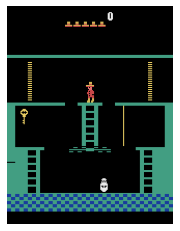

In [5]:
env = gym.make("MontezumaRevenge-v0")
env.reset()


plt.imshow(env.ale.getScreenRGB2())
plt.axis("off")
plt.show()

In [3]:
def plot_norms(env_name, attack_type, episodes, model_name="", xlabel=None):
    plt.figure(2, figsize=(10,10))
    
    plt.title(f"Effect of {attack_type} on {model_name} Performance in {env_name}")
    plt.xlabel('L2 Norm of Noise' if xlabel is None else xlabel)
    plt.ylabel('Reward (avg. over 100 eps) $\pm \sigma$')
    
    for ep, color, label in episodes:
        x, ys = np.array(list(ep.keys())).astype(np.float), np.array(list(ep.values()))
        
        # normalise to the highest reward
        #y = np.mean(ep['0.0']) #for normalising against the first data point
        #y = np.max([np.mean(ep[k]) for k in ep.keys()])
        #ys = (ys - y) / -y
        
        mu = np.mean(ys, axis=1)
        plt.plot(x, mu, label=label, color=color, marker='x', linewidth=2, markersize=12)
        stds = np.std(ys, axis = 1)
        plt.fill_between(x, mu + stds , mu - stds, alpha=0.2, color=color)
    
    plt.legend()#prop={'size': 14})
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('noise_sigma.pdf', format='pdf', dpi=1000)
    
def plot_norms_agreement(env_name, attack_type, episodes, model_name="", xlabel=None):
    #plt.figure(2, figsize=(10,10))
    
    fig, ax1 = plt.subplots(figsize=(10,10))
    plt.title(f"Effect of {attack_type} on {model_name} Performance in {env_name}")
    plt.xlabel('L2 Norm of Noise' if xlabel is None else xlabel)
    
    
    ax2 = ax1.twinx()
    ax1.set_ylabel('Reward (avg. over 100 eps) $\pm \sigma$')
    ax2.set_ylabel('Agreement')
    
    for ep, color, label in episodes:        
        x, yss = np.array(list(ep.keys())).astype(np.float), np.array(list(ep.values()))
        
        ys = []
        for i in range(len(yss)):
            ys.append(list(map(lambda x: x[1], yss[i])))
        
        mu = np.mean(ys, axis=1)
        ax1.plot(x, mu, label=label, color=color, marker='x', linewidth=2, markersize=12)
        stds = np.std(ys, axis = 1)
        ax1.fill_between(x, mu + stds , mu - stds, alpha=0.2, color=color)
        
        ys = []
        for i in range(len(yss)):
            ys.append(list(map(lambda x: x[0], yss[i])))
        
        mu = np.mean(ys, axis=1)
        ax2.plot(x, mu, label=label+" (agr)", color=color, linestyle='dashed')
        stds = np.std(ys, axis = 1)
        #ax2.fill_between(x, mu + stds , mu - stds, alpha=0.2, color=color)
    
    ax2.legend(prop={'size': 14}, loc=3)
    ax1.legend(prop={'size': 14})

def plot_fgsm(env_name, attack_type, episode_durations):
    plt.figure(2, figsize=(10,10))
    
    plt.title(f"Effect of {attack_type} on Performance in {env_name}")
    for kk in ['both', 'goal_only', 'action_only']:
        x, ys = np.array(list(episode_durations[kk].keys())), np.array(list(episode_durations[kk].values()))
        plt.xlabel('$\epsilon$ of Perturbations')
        plt.ylabel('Reward (avg. over 100 eps) $\pm \sigma$')
        
        mu = np.mean(ys, axis=1)
        plt.plot(x, mu, label=kk, marker='x')
        stds = np.std(ys, axis = 1)
        plt.fill_between(x, mu + stds , mu - stds, alpha=0.2)
    
    plt.xticks(rotation=-45)
    plt.legend(prop={'size': 14})
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('fgsm_sigma.pdf', format='pdf', dpi=1000)

In [12]:
def plot_norms_minmax(episodes):
    plt.figure(2, figsize=(10,10))
    
    plt.title('Action Prediction $\mu$ and $min/max$ interval')
    plt.xlabel('L2 Norm of Noise')
    plt.ylabel('Average Reward')
    
    for ep, color, label in episodes:
        x, ys = np.array(list(ep.keys())).astype(np.float), np.array(list(ep.values()))
        
        # normalise to the highest reward
        # y = np.mean(ep[0]) for normalising against the first data point
        #y = np.max([np.mean(ep[k]) for k in ep.keys()])
        #ys = (ys - y) / y
        
        mu = np.mean(ys, axis=1)
        plt.plot(x, mu, label=label, color=color, marker='x')
        stds = np.std(ys, axis = 1)
        plt.fill_between(x, np.max(ys, axis=1) , np.min(ys, axis=1), alpha=0.2, color=color)
    
    plt.legend(prop={'size': 14})
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('noise_minmax.pdf', format='pdf', dpi=1000)

def plot_fgsm_minmax(episode_durations):
    plt.figure(2, figsize=(10,10))
    
    plt.title('Action Prediction $\mu$ and $\pm \sigma$ interval')
    for kk in ['both', 'goal_only', 'action_only']:
        x, ys = np.array(list(episode_durations[kk].keys())), np.array(list(episode_durations[kk].values()))
        plt.xlabel('$\epsilon$')
        plt.ylabel('Average Reward')
        
        mu = np.mean(ys, axis=1)
        plt.plot(x, mu, label=kk, marker='x')
        stds = np.std(ys, axis = 1)
        plt.fill_between(x, np.max(ys, axis=1) , np.min(ys, axis=1), alpha=0.2, color=color)
    
    plt.xticks(rotation=-45)

    plt.legend(prop={'size': 14})
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('fgsm_minmax.pdf', format='pdf', dpi=1000)

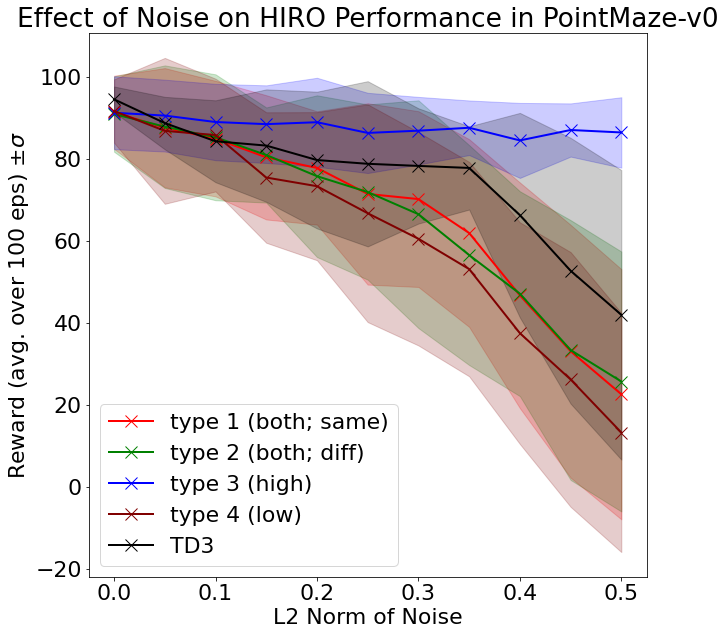

In [6]:
eps = {'both': {0.0: [8.189999999995413, 81.02399999998343, 96.25299999999302, 95.83999999999246, -15.590999999987591, 96.69799999999408, 67.31499999999552, 62.42499999999324, 89.71899999999505, 44.57400000000976, 24.44800000001023], 0.05: [27.205000000018956, 90.9579999999908, 87.60099999998994, 44.559000000013455, 68.0139999999818, 96.42199999999367, 88.99299999998674, 77.71199999997899, 86.62199999999183, 54.729000000009044, 38.6250000000138], 0.1: [58.93199999998585, 82.02499999998592, 80.72599999998525, 42.746000000007605, 88.91399999998157, 96.07199999999258, 91.9249999999933, 86.89299999998929, 86.55499999999482, 68.66499999997961, 48.44500000001031], 0.15: [88.51399999999516, 68.99099999998116, 67.52299999999167, 62.778999999986, 89.9079999999834, 92.75399999999134, 88.50999999999166, 92.63999999998887, 72.82999999999855, 75.5629999999817, 73.78299999998482], 0.2: [87.29599999999081, 67.2349999999791, 29.230000000012204, 85.70599999998893, 88.32099999998027, 89.5669999999879, 80.58699999998278, 91.7879999999861, 53.59400000000644, 90.75899999998893, 72.36499999996988], 0.25: [64.5489999999959, 49.67699999998555, 24.1170000000047, 92.17199999998724, 81.63199999997848, 74.58899999997267, 90.21999999998948, 87.277999999982, 54.936999999998626, 83.5289999999851, 68.75499999998284], 0.3: [59.259999999998335, 47.732999999997766, 5.249999999999917, 91.56099999998507, 72.41399999997572, 66.03199999998722, 89.26399999998323, 88.0269999999831, 33.12100000001292, 71.86899999997009, 64.60199999998751], 0.35: [32.52200000002172, 35.496000000023784, 16.601000000017397, 89.61099999998467, 45.054000000008934, 31.515000000025864, 74.37999999997837, 79.25799999997611, 16.851000000002735, 33.74400000002326, 76.81299999997779], 0.4: [14.584999999999287, 17.72800000000905, 22.13900000002061, 83.61799999997494, 1.1419999999974149, 6.478999999996082, 58.188999999993136, 54.652000000001024, 39.603000000011676, 0.17700000000119764, 86.00899999998215], 0.45: [0.4159999999980393, -1.8669999999994564, 11.970000000015512, 66.86599999997314, -33.258999999967976, -24.79899999997706, 37.4820000000131, 45.13700000000395, 39.89200000000928, -30.459999999972112, 82.7699999999848], 0.5: [-12.06999999999818, -2.4970000000044097, 23.882000000018024, 59.83099999998697, -35.00399999997284, -40.272999999968185, 26.435000000018704, 32.65700000001911, 34.285000000015856, -39.43799999997237, 82.19699999998123]}, 'action_only': {0.0: [6.576999999995843, 81.11699999998065, 96.16899999999313, 94.47599999999116, -24.038999999974, 96.77799999999422, 73.04099999999143, 80.09899999998413, 91.1939999999902, 46.04200000001362, 4.022999999995326], 0.05: [38.833000000013676, 89.78099999998486, 77.28499999999396, 36.289000000016024, 75.26199999997317, 96.70099999999415, 90.44199999999054, 67.97399999998349, 95.4889999999944, 42.93700000001431, 47.78299999999704], 0.1: [59.35099999998839, 83.40899999998557, 75.20599999998528, 49.37000000000696, 88.45799999998297, 95.90799999999274, 89.2569999999876, 71.07699999998596, 93.83699999999315, 61.73799999999606, 52.357999999991556], 0.15: [75.57099999998769, 74.00999999998561, 64.67499999997831, 43.87800000000626, 90.15699999998319, 91.80599999998934, 81.00799999999022, 72.2729999999926, 62.709999999990096, 80.82699999998803, 62.33799999998626], 0.2: [84.49899999999016, 66.8439999999769, 39.19400000001051, 63.60599999999019, 86.88599999998308, 89.04999999998113, 81.76999999998746, 90.44899999998485, 50.57799999998218, 79.5839999999838, 61.54199999998416], 0.25: [75.1109999999915, 46.750999999999884, 6.99099999999819, 85.06499999998165, 82.2979999999773, 70.66299999997334, 88.59399999998983, 84.44799999998374, 49.08300000000279, 79.17499999997871, 55.01599999999619], 0.3: [48.50099999997753, 40.3890000000108, 0.398999999995816, 76.55999999998635, 74.79099999997466, 61.61699999996832, 82.66799999998024, 78.74199999998426, 38.87300000001664, 63.07799999997703, 51.85699999999646], 0.35: [21.862000000014426, 48.39100000000574, -3.558000000002884, 65.07799999998085, 30.897000000020654, 28.329000000012392, 78.6659999999867, 71.64699999997572, 38.69600000001321, 42.42100000002138, 60.5789999999849], 0.4: [-0.719000000002203, 30.261000000021795, -8.658000000004606, 53.34799999999368, 0.7959999999987138, -5.464000000004652, 51.6399999999898, 53.00499999999514, 31.521000000014418, -17.34099999998623, 79.42999999997731], 0.45: [-0.7700000000003058, -4.963000000003466, -13.6489999999998, 52.36599999999533, -29.284999999973433, -28.785999999978245, 40.90600000001636, 29.74900000001552, 37.272000000008795, -35.44199999997349, 76.86499999997898], 0.5: [-14.233999999989123, -14.045999999980317, -26.717999999974545, 33.067000000017515, -30.510999999975233, -38.09699999996835, 26.77200000001305, 18.402000000016393, 19.336000000011037, -43.88899999998435, 58.66899999998492]}, 'goal_only': {0.0: [5.129999999996208, 82.89999999998392, 96.25399999999328, 95.89199999999269, -24.057999999977095, 96.70099999999404, 68.70399999999684, 69.86699999998376, 86.77799999999168, 38.667000000012656, 16.938000000002255], 0.05: [9.618999999997083, 86.86199999998402, 96.29699999999295, 78.10099999998636, -19.6709999999897, 96.73299999999414, 71.07099999998078, 70.36199999999626, 91.18999999999194, 35.723000000015475, 9.86700000001082], 0.1: [18.496000000014252, 78.91399999997907, 93.16299999998927, 72.4079999999812, -12.470999999998664, 96.74399999999412, 75.42199999998493, 81.50299999998073, 88.25599999998914, 49.02199999999791, 39.03900000001773], 0.15: [30.59800000001798, 79.8199999999853, 88.6319999999868, 65.91499999999182, -12.322000000003195, 96.76799999999417, 84.65799999998599, 84.00299999999196, 86.73799999998859, 59.355999999990324, 29.266000000017947], 0.2: [49.18099999998949, 88.1709999999888, 91.44999999999035, 58.57299999998143, -22.496999999978627, 96.75899999999416, 87.22099999998734, 87.94999999998217, 86.72899999999339, 70.7369999999854, 49.71099999999203], 0.25: [47.771000000001514, 90.69999999998456, 87.28699999998749, 62.44799999998235, -4.662000000004914, 96.74099999999413, 78.25799999997942, 89.25899999998514, 83.76699999998696, 75.06299999999221, 44.36100000001504], 0.3: [51.302999999986596, 90.90299999998597, 80.02799999999539, 68.52399999999103, 8.7169999999952, 96.4269999999931, 79.22399999998737, 89.56299999999001, 86.68499999998953, 71.10299999999437, 56.0659999999847], 0.35: [64.39199999997454, 91.01699999998723, 80.52299999998749, 74.49799999998237, 38.09500000002193, 96.49599999999354, 82.71199999998733, 90.3649999999904, 85.17099999999026, 82.67999999999034, 45.98800000000853], 0.4: [62.032000000005425, 89.4769999999852, 68.75799999998478, 70.84899999998532, 53.95299999999537, 95.17299999999233, 89.58799999998921, 82.846999999987, 86.62499999999125, 79.3929999999815, 47.07399999999887], 0.45: [70.38899999999074, 89.53799999998307, 83.87699999999217, 78.50299999997792, 72.76199999997871, 96.43399999999343, 79.70099999999087, 79.94199999998564, 86.42999999999579, 79.1889999999856, 57.09400000000305], 0.5: [76.50699999998838, 91.00899999998482, 75.75399999999131, 88.9339999999903, 81.18299999997315, 95.9609999999928, 84.10199999998623, 89.03899999998723, 89.19899999998758, 81.8489999999927, 54.57299999999151]}}
eps['both_same'] = {0.0: [16.677999999998043, 85.57999999998076, 96.2299999999934, 94.36299999999339, -27.087999999978056, 96.75299999999416, 67.27099999998408, 72.7119999999904, 88.25199999998806, 49.004999999991334, 9.779999999996079], 0.05: [37.2880000000167, 93.92699999998909, 80.03199999998925, 46.55300000000004, 61.15799999997799, 96.34399999999351, 87.48199999998997, 71.84699999998347, 92.51099999999167, 51.54499999999556, 39.540000000017976], 0.1: [60.28899999998411, 86.29199999998588, 68.09999999998357, 51.24399999999963, 88.20599999998134, 95.76499999999226, 87.54599999999006, 83.4189999999849, 93.88199999999478, 64.40699999998658, 45.51400000000859], 0.15: [88.39499999999043, 76.53799999999222, 63.21099999999147, 45.19600000001514, 88.89899999998198, 92.87299999999172, 79.75599999998872, 92.0269999999859, 79.98099999998884, 83.4479999999901, 67.24899999997861], 0.2: [80.18499999998114, 70.6129999999841, 44.857000000014644, 82.74999999998384, 85.95699999998074, 85.0229999999906, 80.3439999999805, 91.64999999998754, 63.631999999989105, 90.55899999998904, 79.820999999986], 0.25: [75.08599999998012, 63.867999999979766, 18.812000000008943, 91.66199999998628, 83.00799999997781, 75.23999999998387, 79.05299999998243, 88.65099999998282, 47.38499999998972, 85.52799999998435, 79.26099999998061], 0.3: [56.17899999999346, 59.77199999998285, 20.89700000001692, 90.39999999998255, 67.83199999997673, 61.455999999976285, 83.53799999998533, 86.39899999998298, 49.18900000000651, 78.46499999997326, 64.71799999998831], 0.35: [34.79300000000804, 39.25700000002244, 16.12000000000389, 88.41799999998302, 36.664000000024686, 46.720000000013215, 76.46099999997837, 76.95999999996938, 44.836000000004084, 27.785000000016662, 76.71199999998022], 0.4: [21.280000000011913, 22.355000000018464, 22.982000000017603, 83.85299999997778, -7.82000000000597, -6.201000000004128, 59.6999999999924, 56.82500000000002, 32.93300000001144, -16.979999999991655, 84.66599999998108], 0.45: [-0.3450000000039839, 7.722999999998926, 15.228000000007771, 70.09099999997731, -27.477999999978, -25.899999999972394, 34.134000000018005, 39.98600000001819, 36.54800000001562, -31.88699999997233, 78.78699999997647], 0.5: [-20.973999999984635, -14.217999999997181, 7.952999999997541, 66.04099999997703, -37.28499999996704, -33.61499999997058, 24.04000000000601, 21.520000000023472, 34.773000000011756, -38.285999999973505, 72.37999999997979]}

eps2 = {'both': {0.0: [94.37999999999394, 96.19999999999317, 39.7070000000156, 13.406000000014863, 95.75499999999234], 0.05: [96.88099999999461, 96.30199999999337, 93.37099999998749, 51.78699999999928, 95.59899999999203], 0.1: [96.60599999999432, 96.43899999999356, 91.92199999998994, 85.66799999999003, 95.4259999999916], 0.15: [92.01599999999067, 92.1419999999928, 85.73899999999401, 95.52299999999065, 94.27499999998955], 0.2: [95.89299999999237, 88.74199999999038, 94.12699999998951, 95.17399999999192, 92.3919999999884], 0.25: [85.54799999998379, 91.16199999998949, 92.72799999998803, 94.61099999999028, 85.71399999998248], 0.3: [91.60899999998763, 84.36199999998078, 89.86199999998313, 92.5039999999906, 86.03999999997954], 0.35: [80.40799999998664, 80.14099999998274, 87.0479999999815, 86.7439999999917, 73.56399999997659], 0.4: [78.1869999999787, 72.1619999999786, 87.17799999998219, 84.07699999998569, 47.60900000000554], 0.45: [76.4799999999757, 73.54599999997544, 83.68399999997833, 77.38199999997975, 16.611999999998787], 0.5: [64.59099999998789, 66.34199999998255, 78.41099999997883, 68.13299999998249, 3.69999999999877]}, 'action_only': {0.0: [95.87299999999571, 96.1969999999931, 35.36800000001512, 22.267000000009574, 95.74399999999235], 0.05: [95.64299999999317, 96.37199999999346, 93.11599999998896, 31.980000000014392, 95.72699999999222], 0.1: [95.139999999994, 96.53199999999374, 91.10999999999007, 65.8599999999865, 93.80199999999022], 0.15: [95.04299999999454, 96.65199999999385, 91.99299999998944, 83.0079999999956, 80.3679999999854], 0.2: [95.83299999999235, 96.5109999999936, 88.2289999999869, 83.76899999999267, 81.50499999998408], 0.25: [89.20999999999295, 95.86999999999243, 91.12199999998614, 93.0529999999887, 85.24799999998083], 0.3: [80.75699999998866, 90.03599999998713, 85.73999999998706, 87.32699999998262, 76.32799999998787], 0.35: [68.93899999998372, 87.22799999998783, 85.67199999998593, 79.9739999999916, 75.55399999997775], 0.4: [65.79599999997664, 82.14399999998021, 86.17299999997721, 77.54499999999092, 38.81900000001211], 0.45: [54.17199999999925, 73.4799999999806, 84.2569999999768, 61.622999999994015, 21.980000000020503], 0.5: [49.084999999994686, 53.4599999999914, 83.75399999997397, 44.152000000007796, 13.330000000006905]}, 'goal_only': {0.0: [97.27599999999504, 96.18299999999306, 45.524999999996965, 6.041999999995065, 95.77099999999238], 0.05: [97.29399999999514, 96.15899999999309, 47.08500000001094, 20.670000000016373, 95.75299999999238], 0.1: [96.97399999999521, 96.22899999999318, 53.249999999993626, 56.062999999980526, 95.64999999999216], 0.15: [97.1969999999949, 93.28299999999226, 70.96199999999608, 64.59599999998784, 95.547999999992], 0.2: [92.71599999998978, 96.11299999999268, 82.74899999998136, 83.06899999998664, 95.5299999999918], 0.25: [89.39099999998851, 84.52499999998861, 90.44199999998793, 78.03399999999627, 95.53099999999213], 0.3: [92.35599999998844, 88.78599999998947, 93.91499999998744, 86.46299999998945, 95.59699999999197], 0.35: [90.95299999999015, 87.30799999998993, 93.98799999999181, 83.45499999998596, 95.48299999999192], 0.4: [89.33099999999592, 85.71799999999256, 92.77699999999193, 91.2879999999889, 95.50099999999276], 0.45: [95.49299999999528, 87.04499999999103, 94.92399999999083, 89.98399999998932, 94.95099999999218], 0.5: [96.34799999999383, 78.3569999999882, 93.63799999999237, 91.05699999998946, 95.29799999999176]}}
eps2['both_same'] = {0.0: [97.28799999999512, 96.134999999993, 39.6250000000146, 7.511999999996949, 95.74199999999234], 0.05: [92.61399999999644, 96.3019999999934, 87.20699999999123, 54.71499999999965, 95.66699999999237], 0.1: [96.71299999999424, 94.99199999999182, 86.44199999998824, 92.28599999999408, 95.15499999999196], 0.15: [95.02499999999198, 93.66499999999058, 92.26999999998847, 94.04399999999279, 93.91299999999013], 0.2: [90.16199999998629, 90.2559999999892, 94.14699999998916, 95.44099999999182, 91.09699999998845], 0.25: [90.18999999998778, 89.95699999998789, 90.14899999998994, 94.60999999999125, 89.10299999998475], 0.3: [82.26699999998483, 89.97999999998956, 91.69599999998556, 90.87599999998922, 89.82799999998183], 0.35: [84.82899999998195, 83.3769999999852, 87.90599999998416, 90.32799999998738, 76.25199999997422], 0.4: [79.56099999998304, 71.58399999998466, 83.82699999997907, 81.91799999998449, 41.96400000001166], 0.45: [74.83599999997891, 70.47599999998826, 78.27599999997781, 79.24099999997509, 10.339999999995307], 0.5: [62.786999999975805, 50.26299999999239, 72.35999999997325, 61.221999999977285, 10.27200000000981]}

eps3 = {'both': {0.0: [97.206999999995], 0.05: [95.72699999999321], 0.1: [85.23999999998739], 0.15: [78.71699999998295], 0.2: [75.91499999999719], 0.25: [72.02699999998532], 0.3: [71.17599999997556], 0.35: [67.8709999999833], 0.4: [46.477000000007976], 0.45: [38.59100000001577], 0.5: [21.7000000000032]}, 'action_only': {0.0: [97.21599999999502], 0.05: [95.73099999999329], 0.1: [86.73399999998257], 0.15: [65.43799999997614], 0.2: [69.57199999999169], 0.25: [51.025999999988564], 0.3: [58.563999999993094], 0.35: [44.87000000000055], 0.4: [36.45800000000751], 0.45: [30.19400000000498], 0.5: [17.380000000016928]}, 'goal_only': {0.0: [97.21899999999498], 0.05: [97.22699999999499], 0.1: [97.24499999999503], 0.15: [97.26199999999508], 0.2: [97.25399999999505], 0.25: [95.78699999999567], 0.3: [91.3619999999882], 0.35: [92.8589999999922], 0.4: [75.09899999999044], 0.45: [79.58199999998321], 0.5: [70.59399999998017]}}
eps3['both_same'] = {0.0: [97.227999999995], 0.05: [95.71599999999489], 0.1: [80.82099999998502], 0.15: [84.69399999999361], 0.2: [80.26599999998378], 0.25: [70.34899999999017], 0.3: [75.68199999997398], 0.35: [63.862999999982364], 0.4: [59.513999999973265], 0.45: [38.43300000001347], 0.5: [18.61300000000819]}

    
for i in eps.keys():
    for ii in eps[i].keys():
        eps[i][ii].pop(0)
        eps[i][ii].pop(4 - 1)
        eps[i][ii].pop(7 - 2)
        eps[i][ii].pop(9 - 3)
        eps[i][ii].pop(10 - 4)
        
        eps2[i][ii].pop(2)
        eps2[i][ii].pop(3 - 1)
        
        eps[i][ii] = list(np.concatenate([eps[i][ii], eps2[i][ii], eps3[i][ii]]))

td3_eps = {0.0: [95.6489999999922, 96.47699999999367, 94.08999999999124, 86.49399999998349, 96.45399999999363, 92.31899999999034, 96.9649999999945, 96.2579999999933, 94.01399999998942, 97.69099999999578], 0.05: [91.41799999998848, 95.39899999999152, 76.23899999998632, 93.69899999998911, 96.12499999999316, 84.95899999998794, 93.45599999999004, 87.20399999999167, 79.71499999998295, 90.1969999999912], 0.1: [79.5459999999889, 94.58099999999062, 77.31799999998296, 94.08699999998953, 96.1749999999929, 78.6459999999869, 79.29899999998185, 86.57999999998412, 63.69599999998767, 94.14899999999152], 0.15: [67.44699999999224, 94.64199999999066, 88.55699999998416, 84.0439999999823, 95.85399999999298, 79.17999999999199, 82.29199999997918, 93.15799999999139, 51.436999999997596, 96.88499999999426], 0.2: [53.96699999999896, 93.59499999998852, 89.45299999998777, 53.515999999987486, 92.37599999998844, 79.54099999998219, 92.02199999998551, 89.39799999998408, 58.12499999999178, 96.23599999999327], 0.25: [51.01399999999653, 91.47899999998447, 94.30799999999033, 30.439000000013202, 83.86599999998843, 79.24899999998584, 89.69899999998151, 88.15799999998261, 85.66399999997984, 95.23399999999172], 0.3: [69.23199999999053, 87.08299999997669, 92.63899999998759, 43.87699999999261, 76.59799999998458, 71.13899999998225, 83.51099999997787, 77.74999999997848, 87.97499999998075, 94.10799999999004], 0.35: [82.98899999997639, 80.44999999997003, 89.08699999998272, 82.07299999997738, 68.96799999997076, 68.73599999998007, 75.65799999997664, 56.22599999998374, 83.2219999999783, 91.61599999998428], 0.4: [80.90599999997556, 59.30899999998187, 84.0659999999778, 86.50799999997967, 64.941999999976, 60.45499999997524, 60.675999999975005, -0.47899999999974324, 76.29399999997729, 91.05699999998623], 0.45: [70.97099999997243, 25.293000000023735, 71.43599999998125, 81.27399999997114, 56.56499999999839, 51.49399999999159, 40.68100000001754, -27.89299999997857, 69.26599999997755, 89.13599999998286], 0.5: [51.502999999993754, 10.579999999994666, 45.10200000000637, 73.74099999997136, 54.775999999985814, 44.557999999995246, 20.20800000001684, -39.894999999969436, 71.98199999997432, 88.11199999998034]}

import json
json = json.dumps(td3_eps)
f = open("td3_episodes.json","w")
f.write(json)
f.close()

plot_norms("PointMaze-v0", "Noise", [\
    (eps['both_same'], "red", "type 1 (both; same)"),\
    (eps['both'], "green", "type 2 (both; diff)"),\
    (eps['goal_only'], "blue", "type 3 (high)"),\
    (eps['action_only'], "maroon", "type 4 (low)"),\
    (td3_eps, "black", "TD3")
   ], "HIRO")

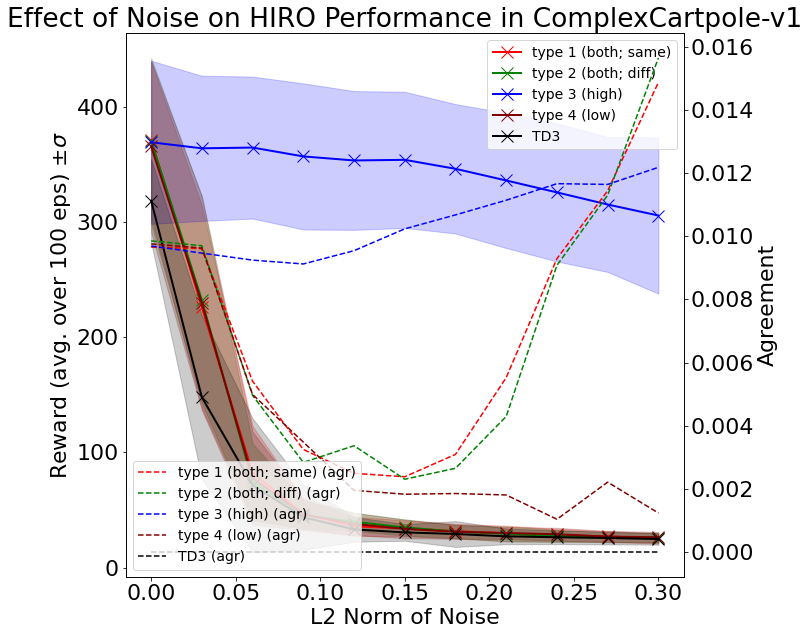

In [13]:
import json

eps = {'both': {0.0: [(0.01144950767117014, 361.68), (0.005, 286.77), (0.01, 407.79), (0.009958963066760085, 380.91), (0.011432040062724467, 300.93), (0.010094382476152021, 486.54), (0.01, 448.25), (0.008553421368547419, 367.12), (0.010152799634499212, 421.6), (0.011894789747026303, 243.24)], 0.03: [(0.012503422469654102, 213.29), (0.007753846153846154, 302.4), (0.00923936398796734, 290.21), (0.007670114699880375, 238.72), (0.005541303232426886, 243.65), (0.004454342984409799, 41.52), (0.01626163158370223, 211.67), (0.011580670587521978, 372.46), (0.011546856297965218, 286.18), (0.01045992924165513, 122.87)], 0.06: [(0.0037690594483467533, 72.02), (0.0027942717429269995, 70.45), (0.004296235679214402, 63.0), (0.003708987161198288, 82.14), (0.01158264502041204, 142.31), (0.002362470469119136, 32.51), (0.0024057738572574178, 40.68), (0.008284023668639054, 98.77), (0.008734249713631157, 108.14), (0.0016795431642593216, 32.91)], 0.09: [(0.001894736842105263, 53.88), (0.0014316392269148174, 47.43), (0.0021945866861741038, 45.04), (0.0010154346060113728, 54.39), (0.015339027366219279, 65.68), (0.00034234851078397807, 29.52), (0.0, 26.16), (0.002398604448320977, 52.31), (0.0034474833371638705, 50.89), (0.00033189512114171923, 31.31)], 0.12: [(0.0019277108433734939, 45.83), (0.001238390092879257, 33.27), (0.001129305477131564, 36.71), (0.000948316737790422, 44.26), (0.01882693700217234, 44.45), (0.002178649237472767, 35.14), (0.0, 21.6), (0.0029069767441860465, 49.77), (0.002871500358937545, 45.65), (0.001651073197578426, 40.54)], 0.15: [(0.0009573958831977022, 44.98), (0.0013033561420658195, 32.45), (0.0006476683937823834, 31.28), (0.001768867924528302, 35.1), (0.014807250446770488, 42.78), (0.00031645569620253165, 32.47), (0.0, 19.83), (0.0015109544195416771, 42.35), (0.0014232849416453174, 37.14), (0.00033955857385398983, 29.92)], 0.18: [(0.0005892751915144372, 35.93), (0.0003465003465003465, 29.13), (0.0013114754098360656, 31.51), (0.0014249073810202336, 38.05), (0.01857311320754717, 35.61), (0.0011248593925759281, 26.72), (0.0, 17.9), (0.0014322543683758235, 36.32), (0.0003191828917969997, 31.57), (0.0014119308153900459, 29.66)], 0.21: [(0.0020491803278688526, 42.7), (0.0029662588060808304, 27.02), (0.002258185923974407, 27.04), (0.004653868528214078, 35.61), (0.01807426881367072, 31.13), (0.002904564315352697, 24.2), (0.0018427518427518428, 16.28), (0.0029145077720207253, 31.81), (0.0024769992922859165, 28.76), (0.0028169014084507044, 28.41)], 0.24: [(0.005427841634738187, 31.66), (0.007369196757553427, 27.97), (0.0065099457504520794, 27.77), (0.006435006435006435, 31.66), (0.025954764553207266, 27.09), (0.007893643539675945, 24.08), (0.007397444519166106, 14.87), (0.008189529102076631, 35.17), (0.007939508506616257, 26.7), (0.007692307692307693, 27.34)], 0.27: [(0.008182748039549948, 29.98), (0.011202389843166542, 27.0), (0.006884057971014493, 28.18), (0.008307372793354102, 29.18), (0.025330812854442344, 26.45), (0.01106104055714871, 24.48), (0.013265950726468731, 15.83), (0.012516469038208168, 31.53), (0.00850546780072904, 24.69), (0.007760532150776054, 27.5)], 0.3: [(0.010267579340385812, 32.36), (0.01650943396226415, 26.23), (0.013471901462663588, 26.93), (0.011666059059423988, 27.82), (0.029411764705882353, 29.3), (0.014764565043894652, 25.2), (0.020080321285140562, 14.94), (0.014876632801161103, 27.67), (0.013061224489795919, 24.5), (0.012371134020618556, 24.31)]}, 'action_only': {0.0: [(0.011375917183322905, 362.53), (0.005, 286.36), (0.01, 403.3), (0.009904952476238118, 381.87), (0.011143485150539284, 291.42), (0.010063532401524777, 480.35), (0.01, 444.64), (0.008303321328531413, 360.59), (0.010156408693885842, 419.93), (0.011648745519713262, 225.28)], 0.03: [(0.012371478726072055, 234.08), (0.007205764611689352, 295.73), (0.00929368029739777, 251.14), (0.008153218983155143, 222.9), (0.006480814730994754, 235.68), (0.003663003663003663, 36.35), (0.016270227252630647, 215.43), (0.01163706891326747, 380.46), (0.010948191593352884, 313.73), (0.010252100840336134, 110.51)], 0.06: [(0.004056047197640118, 67.64), (0.0022310756972111555, 76.11), (0.0031970769582096367, 53.46), (0.0035883450552605138, 86.7), (0.011435425829668134, 182.6), (0.0023902001792650133, 38.34), (0.0037304153195722458, 44.17), (0.00787037037037037, 94.52), (0.007617155158138765, 90.49), (0.003777971519907004, 42.0)], 0.09: [(0.0018096272167933405, 64.07), (0.0004968944099378882, 41.3), (0.0006036824630244491, 34.08), (0.00106928999144568, 50.13), (0.020591165725672534, 66.85), (0.0013568521031207597, 30.88), (0.0, 26.95), (0.0033738191632928477, 51.41), (0.004363183045917307, 59.94), (0.0011823825007389892, 35.7)], 0.12: [(0.0017271157167530224, 44.6), (0.000302571860816944, 33.48), (0.0, 36.99), (0.0002781641168289291, 36.83), (0.013799805636540331, 59.14), (0.00032362459546925567, 31.37), (0.0, 22.35), (0.0016843118383060634, 44.53), (0.001080205238995409, 39.99), (0.0003487966515521451, 29.24)], 0.15: [(0.0005215123859191656, 39.85), (0.0, 31.44), (0.0, 31.54), (0.0005729017473503294, 36.36), (0.01576872536136662, 49.47), (0.0003827018752391887, 26.59), (0.0, 17.63), (0.0010772959870724481, 39.63), (0.0, 31.57), (0.0, 31.19)], 0.18: [(0.00027085590465872155, 38.69), (0.0, 27.02), (0.0006559527714004591, 31.5), (0.0006802721088435374, 30.05), (0.015499425947187142, 35.12), (0.0, 28.71), (0.0, 16.74), (0.0008004268943436499, 39.4), (0.00064, 31.98), (0.0, 31.41)], 0.21: [(0.0002947244326554671, 36.29), (0.0, 29.37), (0.0003367003367003367, 31.05), (0.0, 32.13), (0.016836086404066072, 32.44), (0.0, 28.15), (0.0, 16.21), (0.0002983293556085919, 34.31), (0.00032071840923669016, 31.47), (0.0, 28.51)], 0.24: [(0.0005955926146515784, 35.78), (0.0, 28.41), (0.0, 30.8), (0.0010111223458038423, 30.15), (0.008477053493130663, 34.69), (0.0, 30.27), (0.0, 15.24), (0.0003191828917969997, 32.15), (0.0, 28.08), (0.0, 23.8)], 0.27: [(0.0, 28.84), (0.0009930486593843098, 31.43), (0.0003707823507601038, 27.69), (0.0007135212272565109, 28.73), (0.019011406844106463, 33.04), (0.0, 24.21), (0.0, 14.22), (0.0010567101091933778, 29.14), (0.0, 23.71), (0.0, 27.04)], 0.3: [(0.0, 31.93), (0.0, 25.43), (0.0, 26.84), (0.0, 26.96), (0.012373819602735266, 31.17), (0.0, 26.04), (0.0, 14.64), (0.0, 30.06), (0.0, 24.34), (0.0, 25.85)]}, 'goal_only': {0.0: [(0.011439029970258523, 362.07), (0.005, 287.59), (0.01, 405.8), (0.009914872308462695, 382.0), (0.010332366264569655, 298.99), (0.010063905801841695, 487.19), (0.01, 446.84), (0.008054027013506753, 346.19), (0.010173457449514218, 422.71), (0.011953800177691624, 252.42)], 0.03: [(0.011529371072807978, 360.08), (0.005, 289.34), (0.010020542111328223, 406.11), (0.009610090595124882, 385.41), (0.0072952023912052286, 288.99), (0.010360082880663046, 425.13), (0.01, 453.06), (0.008447304907481898, 357.68), (0.010238558410975734, 417.65), (0.012165839603009444, 255.98)], 0.06: [(0.011765397964586153, 355.45), (0.005, 299.74), (0.01000300090027008, 409.83), (0.009050683829444892, 371.84), (0.00411836485661989, 314.96), (0.010778644809970246, 420.03), (0.01, 461.01), (0.008873615100533442, 360.15), (0.010369141435089175, 409.57), (0.012491559756921, 243.34)], 0.09: [(0.0122517955217575, 347.34), (0.00565, 307.36), (0.00981226533166458, 396.52), (0.007788944723618091, 345.92), (0.002345981232150143, 337.01), (0.011478097915202623, 398.78), (0.01, 467.94), (0.008765979650404383, 341.05), (0.010513588813541502, 407.14), (0.012628111273792094, 220.08)], 0.12: [(0.012712910392495681, 335.39), (0.00625, 319.86), (0.00978228152904585, 392.68), (0.008660858995137763, 351.32), (0.0017319545616626764, 344.87), (0.012603750384260683, 372.16), (0.010059556578749813, 473.69), (0.008807921658734067, 299.57), (0.010514577027242313, 404.65), (0.014322033898305084, 239.78)], 0.15: [(0.014244112433527476, 323.71), (0.0071, 330.15), (0.009934273242687272, 386.79), (0.007876798788184801, 334.88), (0.0027579162410623086, 368.3), (0.01354074820506361, 363.52), (0.010942463819272856, 476.93), (0.00939377389404697, 308.23), (0.011063966915516407, 402.85), (0.015495525356314219, 244.08)], 0.18: [(0.014023732470334413, 310.06), (0.0073, 335.78), (0.010205620632446835, 370.55), (0.007814469372321654, 337.45), (0.002788339670468948, 366.61), (0.014183937823834198, 351.09), (0.012298667215561158, 458.6), (0.009197837114666369, 295.7), (0.011261138140272235, 396.06), (0.017701300839782646, 239.55)], 0.21: [(0.015679101064872282, 294.43), (0.0079, 343.64), (0.009840345416206446, 359.94), (0.008117706747843734, 326.68), (0.003434169991414575, 377.92), (0.015432728261608538, 329.42), (0.013047430618683492, 441.08), (0.008715645385520266, 291.47), (0.011944033670799681, 382.07), (0.017308046400294604, 213.6)], 0.24: [(0.014964905310554893, 279.65), (0.0082, 346.25), (0.00900225056264066, 336.81), (0.008339651250947688, 325.63), (0.0038890853073387543, 379.38), (0.016589394378441032, 304.08), (0.014105590419713283, 411.42), (0.009305015245505205, 304.09), (0.01301468471062482, 381.53), (0.01924848981263438, 187.89)], 0.27: [(0.014402893496092488, 269.64), (0.0082, 352.91), (0.008103241296518607, 313.89), (0.006934673366834171, 300.89), (0.003991713405083119, 388.76), (0.017052090633029666, 279.97), (0.015079887499251989, 384.42), (0.008164313222079589, 293.82), (0.013425573078501495, 375.0), (0.021065302437556426, 192.27)], 0.3: [(0.015194369532329145, 266.02), (0.00915, 355.79), (0.0083, 307.47), (0.007405183628539978, 306.04), (0.003962609225767121, 393.64), (0.01863159542821356, 276.39), (0.016312691914022518, 354.6), (0.006641175286778024, 277.88), (0.014664845930059966, 372.67), (0.021568382994639073, 145.38)]}}
eps['both_same'] = {0.0: [(0.011479738261967628, 361.44), (0.005, 286.63), (0.01, 404.4), (0.009953981592637055, 387.33), (0.009829386299974536, 298.21), (0.010070493454179255, 483.97), (0.01, 445.75), (0.00800280098034312, 356.53), (0.010139931048468871, 420.91), (0.012095230804562505, 268.11)], 0.03: [(0.012737771739130434, 232.33), (0.007219997573110059, 299.97), (0.009324596774193549, 236.44), (0.0072877535687453044, 213.01), (0.006055860088749674, 225.67), (0.003301540719002201, 34.31), (0.016238868517548456, 218.32), (0.011755341945753995, 366.59), (0.01164669449306584, 303.38), (0.010548209775664834, 131.09)], 0.06: [(0.0059915241852988455, 92.94), (0.004647160068846815, 78.52), (0.0024830699774266367, 53.01), (0.0029510395707578805, 93.74), (0.01351832088224831, 160.29), (0.0011419870574800152, 30.3), (0.003629764065335753, 42.75), (0.009538211003838549, 139.47), (0.007472600464961806, 89.75), (0.002735562310030395, 39.99)], 0.09: [(0.0010566356720202875, 55.38), (0.0005041593143433325, 41.24), (0.0015086748805632386, 44.99), (0.001887861053426468, 58.51), (0.01865739893908908, 60.73), (0.0, 31.84), (0.0, 27.13), (0.003917525773195876, 58.0), (0.004964385927045111, 57.27), (0.0, 30.64)], 0.12: [(0.0012130033964095099, 46.31), (0.00093603744149766, 32.75), (0.0, 35.78), (0.000564334085778781, 36.72), (0.019096832172545496, 49.16), (0.00033967391304347825, 29.8), (0.0, 21.18), (0.0019249278152069298, 44.02), (0.0008655510675129833, 35.4), (0.0, 27.1)], 0.15: [(0.0005138746145940391, 41.36), (0.0, 34.1), (0.0006861063464837049, 29.66), (0.0007878151260504202, 40.89), (0.01846066458392502, 36.91), (0.0007309941520467836, 27.66), (0.0, 19.21), (0.0012655024044545685, 41.94), (0.0010770059235325794, 37.77), (0.0003348961821835231, 31.32)], 0.18: [(0.0008351893095768374, 37.97), (0.001650709805216243, 31.07), (0.0006277463904582549, 32.74), (0.0015069318866787222, 34.49), (0.022290331568682084, 36.43), (0.0007412898443291327, 27.04), (0.0, 17.59), (0.00155561317085818, 40.16), (0.0009375, 32.89), (0.0007886435331230284, 25.39)], 0.21: [(0.004415011037527594, 44.54), (0.0026437541308658294, 31.17), (0.0035984166966534724, 27.98), (0.0039126181936746, 31.51), (0.02435723951285521, 29.62), (0.002029220779220779, 25.15), (0.0031191515907673115, 16.03), (0.003234152652005175, 30.96), (0.0033700980392156864, 33.08), (0.004581901489117984, 26.28)], 0.24: [(0.006221719457013574, 36.89), (0.008537490720118782, 27.2), (0.005159958720330237, 29.15), (0.00541573749601784, 31.73), (0.028641285365001747, 29.39), (0.007436399217221135, 25.59), (0.009927200529450696, 15.11), (0.006091989034419738, 33.62), (0.006334125098970704, 25.31), (0.009156810377718427, 26.37)], 0.27: [(0.008466297622924128, 31.48), (0.008775137111517367, 27.42), (0.010112359550561797, 27.0), (0.008849557522123894, 29.62), (0.026492537313432835, 26.85), (0.010510510510510511, 26.7), (0.010848755583918315, 15.67), (0.01177968799745304, 33.78), (0.011235955056179775, 24.92), (0.00735564545788893, 27.31)], 0.3: [(0.010814249363867684, 32.07), (0.01101061738104601, 25.52), (0.014660493827160493, 25.92), (0.014135556361000362, 27.98), (0.02447676481021639, 28.51), (0.015537848605577689, 25.1), (0.018922852983988356, 13.74), (0.011385199240986717, 26.38), (0.014226709499770536, 21.79), (0.013540422142572681, 25.69)]}

s = eps['both'][0.0]
top_10_best_i = sorted(range(len(s)), key=lambda k: -s[k][1])[:10]

for i in eps.keys():
    for ii in eps[i].keys():
        eps[i][ii] = list(map(lambda x: tuple(x), np.array(eps[i][ii])[top_10_best_i]))

import json
json = json.dumps(eps)
f = open("hiro_episodes.json","w")
f.write(json)
f.close()

td3_eps = {0.0: [300.64, 295.84, 266.15, 328.21, 334.5, 276.86, 395.97, 355.04, 320.83, 311.23], 0.03: [169.8, 141.31, 59.83, 118.11, 301.07, 189.85, 51.99, 198.27, 163.99, 84.78], 0.06: [72.56, 51.87, 36.68, 43.46, 240.14, 68.07, 37.64, 51.44, 76.22, 36.18], 0.09: [46.6, 34.89, 26.73, 21.38, 125.83, 39.22, 31.12, 40.41, 39.71, 31.1], 0.12: [33.88, 29.43, 30.68, 16.93, 60.95, 34.84, 29.06, 35.65, 34.21, 25.35], 0.15: [33.44, 27.97, 28.92, 15.12, 46.26, 32.54, 28.06, 30.99, 33.55, 28.32], 0.18: [26.7, 25.33, 25.93, 12.25, 58.84, 26.88, 24.68, 30.74, 33.95, 25.88], 0.21: [26.3, 26.57, 26.99, 12.66, 41.68, 26.58, 23.04, 32.14, 27.87, 26.91], 0.24: [26.97, 29.64, 26.59, 12.2, 35.41, 27.02, 24.46, 32.79, 25.38, 22.6], 0.27: [25.29, 26.59, 24.82, 11.67, 34.92, 27.02, 24.85, 30.52, 26.36, 24.33], 0.3: [27.38, 25.38, 23.27, 11.44, 29.55, 25.18, 26.84, 29.74, 24.32, 24.61]}
for i in td3_eps.keys():
    td3_eps[i] = list(map(lambda x: (0.0, x), td3_eps[i]))
    
import json
json = json.dumps(td3_eps)
f = open("td3_episodes.json","w")
f.write(json)
f.close()
    
plot_norms_agreement("ComplexCartpole-v1", "Noise", [\
    (eps['both_same'], "red", "type 1 (both; same)"),\
    (eps['both'], "green", "type 2 (both; diff)"),\
    (eps['goal_only'], "blue", "type 3 (high)"),\
    (eps['action_only'], "maroon", "type 4 (low)"),\
    (td3_eps, "black", "TD3"),\
   ], "HIRO")

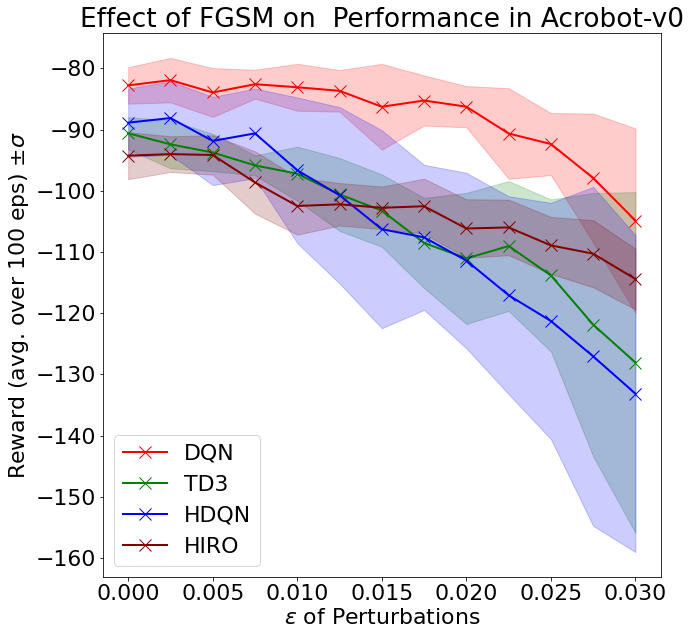

In [69]:
import json
base_url = "acrobot/fgsm_targeted"

plot_norms("Acrobot-v0", "FGSM", [\
    (json.load(open(f"{base_url}/dqn_episodes.json")), "red", "DQN"),\
    (json.load(open(f"{base_url}/td3_episodes.json")), "green", "TD3"),\
    (json.load(open(f"{base_url}/hdqn_episodes.json"))['both'], "blue", "HDQN"),\
    (json.load(open(f"{base_url}/hiro_episodes.json"))['both'], "maroon", "HIRO"),\
   ], xlabel='$\epsilon$ of Perturbations')

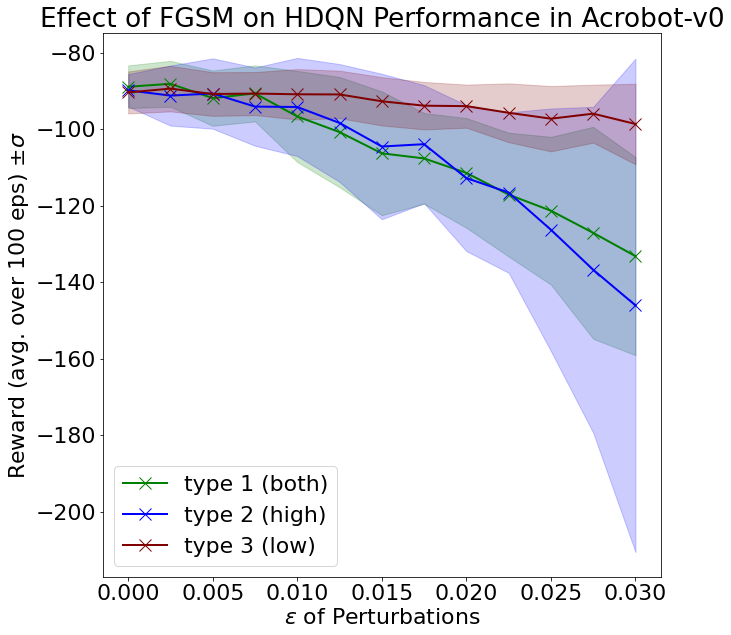

In [71]:
import json
base_url = "acrobot/fgsm_targeted"
model = "hdqn"
plot_norms("Acrobot-v0", "FGSM", [\
    (json.load(open(f"{base_url}/{model}_episodes.json"))['both'], "green", "type 1 (both)"),\
    (json.load(open(f"{base_url}/{model}_episodes.json"))['goal_only'], "blue", "type 2 (high)"),\
    (json.load(open(f"{base_url}/{model}_episodes.json"))['action_only'], "maroon", "type 3 (low)"),\
    #(json.load(open(f"{base_url}/{model}_episodes.json"))['action_only'], "maroon", "type 4 (low)"),\
   ], "HDQN", '$\epsilon$ of Perturbations')

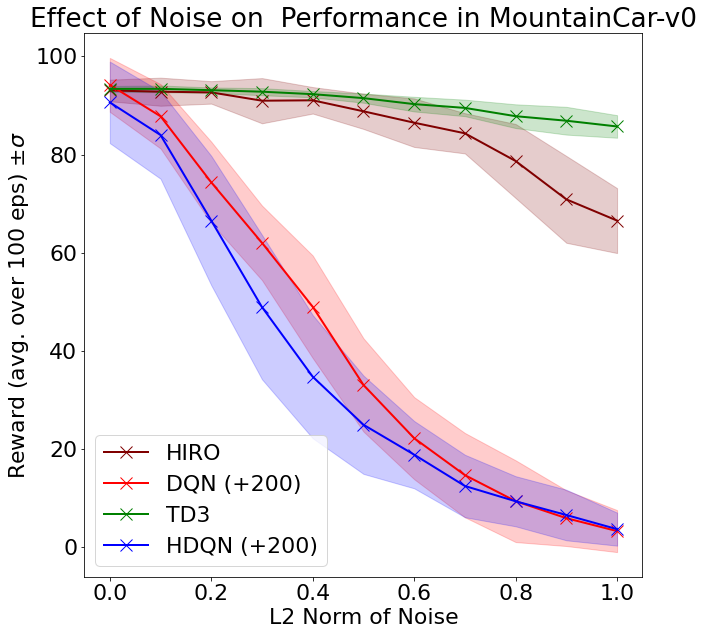

In [33]:
import json
dqn = json.load(open("car/noise/dqn_episodes.json"))
for i in dqn.keys():
    for ii in range(len(dqn[i])):
        dqn[i][ii] += 200

hdqn = json.load(open("car/noise/hdqn_episodes.json"))
for i in hdqn.keys():
    for ii in range(len(hdqn[i])):
        hdqn[i][ii] += 200

plot_norms("MountainCar-v0", "Noise", [\
    (json.load(open("car/noise/hiro_episodes.json")), "maroon", "HIRO"),\
    (dqn, "red", "DQN (+200)"),\
    (json.load(open("car/noise/td3_episodes.json")), "green", "TD3"),\
    (hdqn, "blue", "HDQN (+200)")
   ])

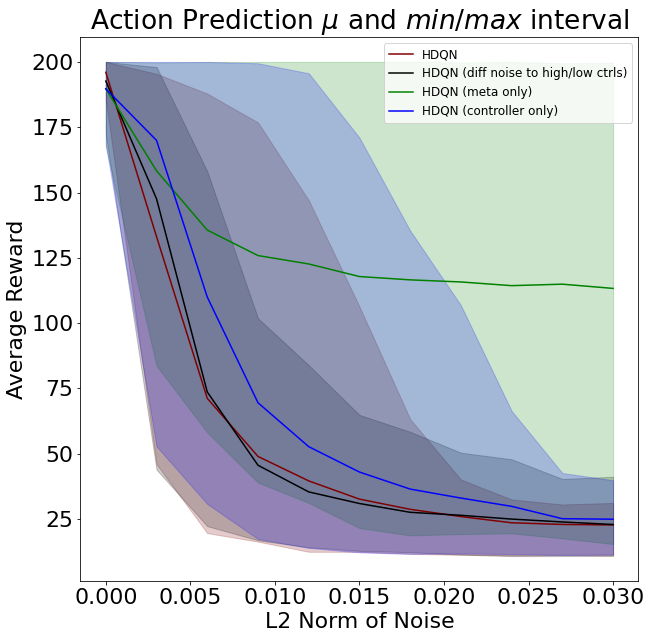

In [24]:
import json
plot_norms_minmax([\
    #(json.load(open("absolute_noise/dqn_episodes.json")), "red", "DQN"),\
    #(json.load(open("absolute_noise/td3_episodes.json")), "green", "TD3"),\
    #(json.load(open("absolute_noise/hiro_episodes.json")), "maroon", "HIRO"),\
    #(json.load(open("absolute_noise_different/hiro_episodes.json")), "black", "HIRO (diff noise to high/low ctrls)"),\
    #(json.load(open("absolute_noise_meta_only/hiro_episodes.json")), "green", "HIRO (meta only)"),\
    #(json.load(open("absolute_noise_ctrl_only/hiro_episodes.json")), "blue", "HIRO (controller only)")
    (json.load(open("absolute_noise/hdqn_episodes.json")), "maroon", "HDQN"),\
    (json.load(open("absolute_noise_different/hdqn_episodes.json")), "black", "HDQN (diff noise to high/low ctrls)"),\
    (json.load(open("absolute_noise_meta_only/hdqn_episodes.json")), "green", "HDQN (meta only)"),\
    (json.load(open("absolute_noise_ctrl_only/hdqn_episodes.json")), "blue", "HDQN (controller only)")
  ])

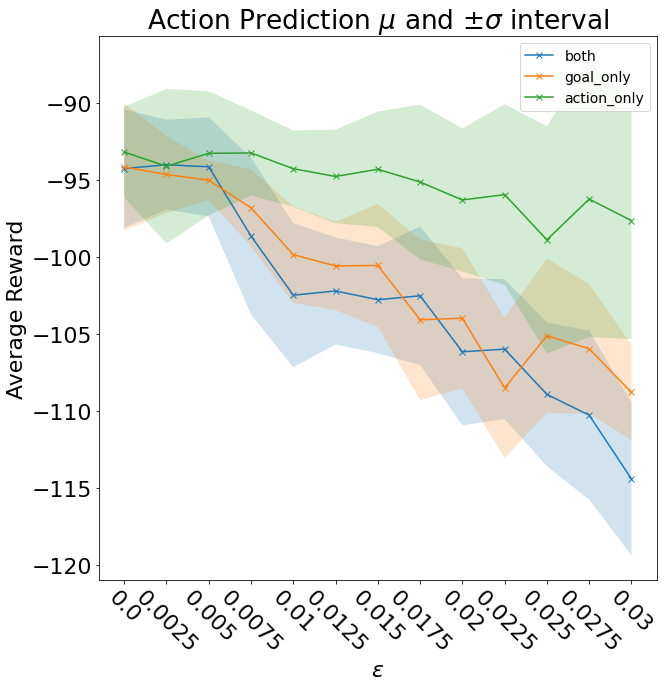

In [16]:
import json
plot_fgsm(json.load(open("acrobot/fgsm_targeted/hiro_episodes.json")))

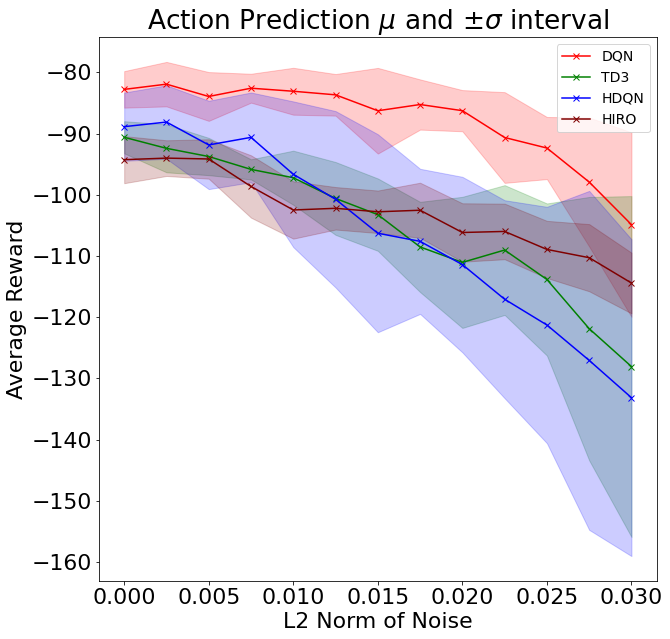

In [15]:
import json
plot_norms([\
    (json.load(open("acrobot/fgsm_targeted/dqn_episodes.json")), "red", "DQN"),\
    (json.load(open("acrobot/fgsm_targeted/td3_episodes.json")), "green", "TD3"),\
    (json.load(open("acrobot/fgsm_targeted/hdqn_episodes.json"))['both'], "blue", "HDQN"),\
    (json.load(open("acrobot/fgsm_targeted/hiro_episodes.json"))['both'], "maroon", "HIRO")
   ])

In [47]:
import json
eps = json.load(open("acrobot/fgsm_untargeted/td3_episodes.json"))
eps_sub = {0.0: [-86.49], 0.0025: [-90.24], 0.005: [-92.97], 0.0075: [-93.18], 0.01: [-94.87], 0.0125: [-93.62], 0.015: [-96.17], 0.0175: [-118.05], 0.02: [-120.8], 0.0225: [-143.29], 0.025: [-200.74], 0.0275: [-227.1], 0.03: [-289.65]}

for i in eps.keys():
    eps[i][2] = eps_sub[float(i)][0]

json = json.dumps(eps)
f = open("td3_episodes.json","w")
f.write(json)
f.close()

In [11]:
hiro1 = {'both': {0.0: [93.8314225698464, 93.92023067366725, 94.53884111025145, 94.01082026783635, 93.48687742316791, 93.91282252589593, 94.3153990968144], 0.025: [92.17632844530289, 93.34774087646333, 94.64143158244802, 93.60997356164573, 93.97629040562319, 94.18258756697816, 93.1867165526663], 0.05: [94.11130100837583, 93.40901651286698, 94.62878026850436, 93.2906246022272, 94.23750783985804, 93.6182783282148, 93.03992394780971], 0.07500000000000001: [88.9313309946977, 93.49406526627003, 94.54752369540225, 93.31618631766722, 94.07826455667599, 93.59474880909913, 92.89143342909671], 0.1: [80.21431033832087, 93.30012491927877, 94.34648252483285, 93.36557139416455, 94.05981512634658, 93.79654089681667, 92.62191497739838], 0.125: [73.13969163422374, 93.37421234607258, 94.01113445761983, 93.22878623801743, 93.65822135317843, 93.2322534255169, 92.1907092516812], 0.15000000000000002: [76.26659475589946, 91.1981647940952, 93.68409850605438, 92.74118526567257, 93.46410811448725, 92.85181701382959, 91.80233296838465], 0.17500000000000002: [29.935284081260683, 71.6461792926723, 93.18060970895799, 90.0871254203134, 93.68750531095183, 91.64791451284995, 91.35006108991801], 0.2: [36.97014612885636, 83.69596438148403, 92.6666168609277, 91.96227527260909, 93.56948344200316, 90.83054956953309, 76.97401078541029], 0.225: [37.532592276477956, 68.38731739335024, 92.66529599933924, 90.81385153907908, 92.72347907723866, 85.33513098003947, 70.86720672281226], 0.25: [40.04614878834503, 70.65389130310373, 91.35153722779408, 84.62213519582953, 92.39786240378858, 89.90810026833981, 74.03517221560045], 0.275: [55.847419959602966, 67.60408149895461, 91.240601480054, 73.60070969353369, 92.05241147276007, 85.3261192148455, 47.650639897358154], 0.30000000000000004: [49.5706450185435, 56.477136106494555, 91.3806237993104, 67.53615170872241, 91.69786233908792, 67.57214214298466, 40.54388739964276]}, 'goal_only': {0.0: [93.91293568381681, 93.71137071411398, 94.55726525181552, 94.1345034901812, 93.85570590457053, 92.94218618577317, 94.02445949652284], 0.025: [92.90948573382737, 92.643012479752, 94.64914903408535, 93.6996939601111, 94.00199484401551, 94.01342374009519, 93.66163185799789], 0.05: [92.0277728563186, 93.71143274429201, 94.61013003297622, 93.72757796442156, 93.9849318798413, 93.88013129248019, 93.3068775245618], 0.07500000000000001: [84.22830292664293, 93.27938770808345, 94.5700588926662, 92.89199256650423, 94.41279540784956, 93.66456843242959, 93.01478908012628], 0.1: [78.29085011081722, 93.27710347401923, 94.39263051828435, 93.31375824914643, 94.02666321509385, 92.62769430203703, 92.17475891986534], 0.125: [78.22363723844127, 93.31216795149801, 94.23744010248986, 92.92379219576944, 94.08557378694559, 93.34142905191312, 92.24996918190962], 0.15000000000000002: [57.06771978990634, 88.9920978641728, 93.82440458747519, 92.73008734554877, 93.8133276980084, 90.12474034958093, 91.9514632396879], 0.17500000000000002: [20.86183588826175, 74.67422706535734, 93.01963688547791, 90.31651544799836, 93.69076264826818, 90.49709808032082, 91.23880342331469], 0.2: [34.22683492313501, 68.48546700908986, 92.39206846832775, 91.96431695197727, 93.53600348893717, 81.00157868266446, 78.05758495289955], 0.225: [37.75409434371617, 61.44398150617264, 91.90410575449089, 91.99268543851403, 93.1852735393575, 85.73919846395944, 73.00262166866962], 0.25: [44.55063979879333, 54.37015446259573, 91.45911549619535, 76.72364939651148, 92.58638179046869, 80.74715231170357, 68.22503789419883], 0.275: [49.94784806064659, 58.547162191373616, 91.07163307318642, 58.39663712608058, 91.93728938842786, 76.75822347502913, 49.818247896794745], 0.30000000000000004: [43.93830914389634, 49.45985017252759, 91.55340736282102, 50.30938872654204, 91.68680345591183, 71.48395980174303, 40.602299080574184]}, 'action_only': {0.0: [94.02433001678769, 94.02252251781391, 94.60227062391198, 93.97466306387031, 93.57608746456904, 94.02791979469652, 94.01021749093056], 0.025: [92.82531924057963, 93.81892122029778, 94.60007744206911, 94.24513349860328, 93.62351049704897, 93.84225988815005, 94.50056309243196], 0.05: [92.99729393387297, 93.57028796114678, 94.65420012448351, 94.02418424146907, 93.75607098579844, 93.91483792969758, 94.1349183517037], 0.07500000000000001: [94.09321850456205, 93.5187122548122, 94.60327743427784, 94.02727206436207, 93.46726591337537, 94.11281690519547, 94.10553485912953], 0.1: [93.88473909864348, 93.99484005974178, 94.58485311724137, 94.21982894669847, 93.78758359970296, 93.86089190985953, 94.06510145264888], 0.125: [93.88633997101505, 93.59909787135352, 94.65015968722619, 94.2268815940769, 93.93352863794011, 93.91606557277589, 94.20808242427852], 0.15000000000000002: [94.02703532774656, 93.48755998284149, 94.65083960771125, 93.9745825930205, 93.69210918084077, 93.84025064160843, 93.92889979335959], 0.17500000000000002: [92.83067669103451, 92.86882654934647, 94.61235728388965, 93.99599749301366, 93.80473271654074, 93.82709852430868, 94.07746505353032], 0.2: [93.65533160239669, 93.5406028191089, 94.62798080371951, 94.26085175780437, 93.56240225022799, 93.75269895518268, 94.21808451616442], 0.225: [93.90424288523792, 93.86837363320967, 94.61328694629707, 94.32223084986622, 93.7948806246513, 93.91233089696414, 93.88529469144248], 0.25: [94.11884709177758, 93.78150462189947, 94.56056817506587, 93.91469319532487, 93.894741725221, 93.90451492622815, 94.12583877279373], 0.275: [93.9909963031579, 94.02386725486544, 94.59882760976377, 94.1406063361252, 93.57655739921405, 94.07978398612622, 94.34499654726604], 0.30000000000000004: [93.92402042480325, 93.76378637670264, 94.6315655330152, 94.19889854342877, 93.5449384269182, 93.88831335562418, 93.97132838236607]}}
hiro2 = {'both': {0.0: [94.65581239573456, 92.66751295860162, 86.62242743271442], 0.025: [94.62823837986264, 92.19800348037879, 89.46198138438696], 0.05: [94.68437191896294, 91.59844014872206, 89.2322777128791], 0.07500000000000001: [94.5267458479354, 91.22928898094948, 89.43479372687081], 0.1: [94.23229243924594, 91.69083195541367, 89.01962934425872], 0.125: [93.8771682160986, 91.04619001625866, 88.81757861165994], 0.15000000000000002: [93.65306888549547, 91.0207930933348, 88.74376190816747], 0.17500000000000002: [93.18806652712509, 90.24393572768659, 88.72404389191149], 0.2: [93.1758649528023, 90.28213235114976, 88.74485048598874], 0.225: [92.6778994586106, 86.28136008164589, 88.7990495816969], 0.25: [92.28091107339243, 80.86364002838398, 88.87912624374654], 0.275: [92.13680546360224, 71.54395190299579, 88.81051879429383], 0.30000000000000004: [88.88953604688015, 56.49340783169192, -15.003525186455638]}, 'goal_only': {0.0: [94.66496683158131, 92.7167902316335, 87.62204297361313], 0.025: [94.63388995793433, 92.11713100313071, 89.35077184379263], 0.05: [94.49777597194367, 91.72862132815693, 88.71640093552273], 0.07500000000000001: [94.26435170285818, 91.09520456654693, 86.40854480272225], 0.1: [94.27916916494416, 91.21495291560237, 89.0609774890319], 0.125: [94.04924962658087, 90.97017957601784, 88.96973595792008], 0.15000000000000002: [93.70947021697769, 90.55369649671924, 88.74698389942272], 0.17500000000000002: [93.43021056655917, 90.47768604882005, 88.73432388054024], 0.2: [93.06388811112782, 87.29151766097348, 88.71945421322069], 0.225: [92.93691694777897, 86.05919770646868, 88.80936507736996], 0.25: [92.55307224472959, 76.69927967152933, 88.88920289504107], 0.275: [92.2056230618204, 65.27993592410779, 88.92128788789027], 0.30000000000000004: [91.23567962173819, 59.90810346785916, -15.061038384689844]}, 'action_only': {0.0: [94.45417464279332, 92.17920115569815, 88.85416414385594], 0.025: [94.57309196515227, 92.21591354035573, 84.61669222719864], 0.05: [94.64678434496336, 92.5627862591971, 85.54904339382469], 0.07500000000000001: [94.57969177812201, 92.61028871885895, 84.5644783487915], 0.1: [94.6223351031618, 92.41385684203847, 84.63204434460644], 0.125: [94.65996735891903, 92.47317017082327, 87.62619736015547], 0.15000000000000002: [94.63808356107651, 92.44749306492055, 88.75387634064069], 0.17500000000000002: [94.58667003140135, 92.30472894056454, 90.7241781768586], 0.2: [94.5269651007118, 92.23908565167898, 86.92506616351828], 0.225: [94.65965016048403, 92.7756064309396, 89.76020713771649], 0.25: [94.34936455380355, 92.80661530235864, 86.81803010691041], 0.275: [94.63280516822749, 92.63740874297892, 86.86167738104417], 0.30000000000000004: [94.64195680337836, 92.1948340611795, 89.60262617611345]}}

In [12]:
hiro = {}
for i in hiro1.keys():
    hiro[i] = {}
    for ii in hiro1[i].keys():
        hiro[i][ii] = list(np.concatenate([hiro1[i][ii], hiro2[i][ii]]))

In [19]:
hiro1 = {0.0: [-94.07, -95.92, -161.92, -92.03, -81.66, -86.68, -94.26, -82.44, -89.55, -86.94], 0.03: [-101.28, -87.51, -90.57, -88.37, -80.78, -91.99, -92.01, -86.09, -94.4, -84.15], 0.06: [-106.55, -89.6, -94.41, -94.66, -83.68, -93.99, -93.82, -88.48, -102.47, -92.38], 0.09: [-113.13, -97.75, -96.38, -99.31, -91.38, -98.38, -96.22, -92.44, -115.87, -93.51], 0.12: [-126.98, -98.23, -102.91, -108.38, -96.59, -104.3, -102.85, -103.32, -125.41, -102.28], 0.15: [-139.33, -101.35, -106.73, -115.51, -110.76, -112.27, -107.53, -104.12, -137.16, -109.8], 0.18: [-135.98, -113.66, -110.95, -124.25, -113.52, -116.05, -110.79, -108.91, -149.37, -119.03], 0.21: [-141.8, -112.5, -119.91, -144.96, -117.71, -124.25, -123.77, -114.01, -156.68, -122.75], 0.24: [-163.26, -120.49, -131.31, -148.31, -134.45, -140.98, -128.29, -122.85, -166.32, -135.55], 0.27: [-180.1, -137.48, -151.21, -176.21, -134.42, -147.82, -140.51, -131.7, -188.78, -143.6], 0.3: [-186.79, -135.37, -160.23, -186.39, -141.64, -156.07, -149.98, -132.57, -187.63, -154.6]}
hiro2 = {0.0: [-91.89], 0.03: [-94.96], 0.06: [-99.97], 0.09: [-101.06], 0.12: [-107.54], 0.15: [-114.63], 0.18: [-117.84], 0.21: [-125.39], 0.24: [-141.21], 0.27: [-148.73], 0.3: [-153.65]}

for i in hiro1.keys():
    #pass
    hiro1[i].pop(2)
    #hiro1[i].pop(12 - 1)
    #hiro1[i].pop(13 - 2)
    #hiro1[i].pop(16 - 3)
    #hiro1[i].pop(17 - 4)
    #hiro1[i][ii].pop(18 - 4)
    #hiro2[i][ii].pop(0)
    #hiro2[i] = np.array(hiro2[i])[[0, 1, 2, 3, 7, 8, 11]]

hiro = {}
for i in hiro1.keys():
    all_i = list(np.concatenate([hiro1[i], hiro2[i]]))
    hiro[i] = all_i

import json
json = json.dumps(hiro)
f = open("hdqn_episodes.json","w")
f.write(json)
f.close()

In [3]:
import json

eps =  {0.0: [-93.91, -95.54, -91.59, -92.73, -95.01, -98.41, -96.95, -91.0, -89.91, -95.91, -100.09], 0.03: [-93.6, -93.66, -95.71, -95.19, -94.63, -99.08, -94.35, -96.21, -92.19, -94.12, -92.86], 0.06: [-99.76, -93.13, -92.21, -97.11, -95.15, -106.42, -97.46, -95.88, -93.62, -95.44, -95.92], 0.09: [-106.63, -101.1, -97.57, -103.31, -94.87, -97.69, -108.47, -99.23, -94.84, -95.19, -106.58], 0.12: [-104.24, -100.83, -101.77, -102.52, -98.9, -100.97, -97.84, -96.06, -99.38, -104.41, -110.12], 0.15: [-111.47, -100.84, -98.91, -105.81, -100.49, -107.7, -104.93, -105.57, -105.92, -105.93, -107.48], 0.18: [-118.72, -102.17, -101.15, -103.05, -111.0, -103.73, -114.43, -109.4, -107.21, -107.48, -112.66], 0.21: [-122.15, -110.63, -106.67, -110.36, -109.06, -106.47, -115.35, -99.58, -116.53, -106.59, -123.0], 0.24: [-134.01, -115.2, -112.33, -112.65, -113.96, -112.87, -128.73, -106.25, -116.09, -108.76, -136.1], 0.27: [-126.34, -116.29, -112.28, -129.59, -110.86, -112.36, -129.84, -107.48, -114.89, -109.58, -132.33], 0.3: [-136.54, -115.02, -130.52, -127.41, -121.12, -128.19, -131.8, -115.24, -113.7, -111.55, -143.11]}
for i in eps.keys():
    eps[i].pop(10)
json = json.dumps(eps)
f = open("hiro_episodes.json","w")
f.write(json)
f.close()

In [55]:
import json
eps = {'both': {0.0: [-95.42, -86.81, -138.19, -92.18, -76.88, -86.79, -92.76, -83.74, -89.99, -87.48, -96.63], 0.0025: [-97.86, -87.41, -137.33, -90.22, -79.28, -87.72, -92.62, -79.24, -94.69, -82.09, -90.01], 0.005: [-99.11, -91.32, -115.66, -103.11, -80.49, -90.01, -93.18, -79.94, -99.06, -88.69, -93.62], 0.0075: [-100.9, -89.73, -92.43, -101.49, -79.81, -91.28, -86.52, -80.18, -98.52, -88.17, -89.56], 0.01: [-96.07, -87.38, -98.21, -127.77, -95.2, -95.2, -91.32, -81.33, -104.08, -90.4, -97.7], 0.0125: [-114.32, -89.41, -94.78, -134.6, -88.25, -104.52, -93.53, -81.97, -105.25, -96.2, -99.27], 0.015: [-119.39, -93.05, -95.29, -136.2, -91.94, -129.98, -93.21, -88.91, -111.85, -98.06, -100.22], 0.0175: [-114.82, -95.79, -101.12, -132.13, -98.94, -119.49, -100.48, -91.72, -115.45, -103.77, -103.49], 0.02: [-117.03, -94.04, -104.66, -148.44, -108.25, -114.03, -99.34, -101.1, -117.83, -108.11, -105.86], 0.0225: [-127.63, -96.43, -108.53, -142.31, -111.32, -116.94, -100.84, -105.22, -124.74, -143.65, -101.58], 0.025: [-122.41, -100.07, -116.84, -134.85, -113.51, -123.98, -102.28, -103.73, -149.51, -157.32, -105.11], 0.0275: [-124.3, -97.06, -129.0, -126.81, -142.27, -116.82, -104.03, -103.14, -185.92, -164.52, -105.71], 0.03: [-146.24, -112.42, -128.89, -128.34, -165.85, -123.29, -107.4, -102.56, -170.94, -167.65, -106.83]}, 'goal_only': {0.0: [-92.32, -93.01, -152.67, -92.75, -82.45, -89.26, -93.69, -82.29, -89.85, -87.79, -94.79], 0.0025: [-96.31, -88.03, -143.17, -106.52, -80.96, -90.55, -93.16, -79.42, -93.23, -85.05, -98.65], 0.005: [-94.1, -86.8, -105.78, -114.24, -78.01, -89.63, -90.71, -81.05, -89.04, -89.93, -92.98], 0.0075: [-101.48, -91.83, -107.64, -117.17, -79.6, -99.99, -94.01, -84.23, -92.47, -83.81, -96.06], 0.01: [-91.48, -89.53, -91.67, -128.87, -84.41, -95.6, -90.61, -80.83, -97.27, -84.44, -98.64], 0.0125: [-96.54, -95.19, -91.76, -127.64, -85.81, -125.67, -89.96, -80.92, -97.93, -83.64, -100.1], 0.015: [-102.71, -94.57, -93.55, -137.14, -92.88, -144.72, -93.62, -89.0, -99.12, -86.95, -104.26], 0.0175: [-104.31, -98.65, -94.47, -142.21, -100.04, -118.09, -92.12, -87.88, -105.34, -87.5, -102.71], 0.02: [-115.98, -106.44, -93.03, -156.34, -106.16, -138.61, -100.87, -87.44, -109.0, -104.78, -101.88], 0.0225: [-105.39, -95.93, -90.67, -115.6, -133.1, -159.92, -102.2, -87.51, -121.6, -138.68, -105.43], 0.025: [-102.84, -99.07, -96.23, -114.24, -148.99, -198.87, -106.1, -91.58, -143.53, -150.02, -107.32], 0.0275: [-123.53, -103.61, -94.32, -122.7, -165.37, -243.65, -104.71, -95.08, -139.06, -163.25, -106.08], 0.03: [-123.79, -99.48, -93.5, -109.61, -181.54, -321.58, -106.77, -100.75, -168.19, -139.56, -108.82]}, 'action_only': {0.0: [-99.28, -92.73, -180.74, -90.72, -78.76, -88.72, -95.18, -83.81, -89.29, -93.53, -91.66], 0.0025: [-100.16, -94.33, -144.34, -90.44, -77.36, -87.7, -87.14, -84.46, -92.16, -86.19, -93.67], 0.005: [-95.38, -97.7, -143.47, -92.13, -77.74, -85.01, -94.52, -88.47, -95.5, -88.53, -92.85], 0.0075: [-102.32, -91.2, -181.0, -90.75, -80.09, -89.42, -93.57, -85.19, -93.44, -87.12, -93.47], 0.01: [-100.72, -95.2, -181.27, -97.18, -78.42, -87.51, -90.85, -81.67, -94.54, -88.68, -93.72], 0.0125: [-102.34, -89.08, -161.5, -92.39, -80.13, -86.7, -95.31, -84.52, -98.24, -90.2, -89.99], 0.015: [-97.2, -97.11, -198.74, -100.0, -78.33, -89.78, -94.25, -88.12, -96.23, -87.69, -98.07], 0.0175: [-96.13, -97.45, -176.85, -98.69, -80.03, -86.09, -93.39, -101.69, -99.02, -93.65, -92.12], 0.02: [-96.72, -93.76, -154.36, -100.95, -80.82, -88.03, -93.67, -97.2, -99.51, -96.74, -92.07], 0.0225: [-94.4, -104.02, -163.13, -105.82, -80.3, -87.86, -90.87, -97.61, -104.07, -99.26, -92.61], 0.025: [-96.36, -97.6, -160.66, -109.22, -80.72, -89.08, -92.14, -100.92, -109.3, -103.78, -93.15], 0.0275: [-96.48, -90.59, -186.5, -103.03, -80.42, -94.38, -88.91, -99.78, -108.76, -100.72, -96.04], 0.03: [-95.89, -106.31, -193.1, -110.83, -79.59, -90.73, -90.76, -100.08, -117.32, -102.21, -92.39]}}

for i in eps.keys():
    for ii in eps[i].keys():
        eps[i][ii].pop(2)
json = json.dumps(eps)
f = open("hdqn_episodes.json","w")
f.write(json)
f.close()

In [13]:
import json
# both, goal_only, action_only
eps = {'both': {0.0: [-96.17, -94.43, -90.44, -91.18, -97.16, -99.5, -90.96, -87.17, -91.09, -91.54, -91.38], 0.0025: [-94.39, -96.49, -98.41, -98.87, -97.61, -101.71, -95.09, -90.02, -89.6, -98.97, -89.62], 0.005: [-92.88, -95.86, -99.05, -90.51, -95.32, -107.21, -101.56, -89.29, -92.37, -97.51, -85.74], 0.0075: [-93.3, -98.19, -102.04, -97.52, -95.06, -102.0, -94.96, -93.54, -96.87, -97.15, -92.15], 0.01: [-94.97, -95.96, -97.33, -97.37, -99.99, -102.52, -100.63, -95.73, -94.56, -101.69, -88.96], 0.0125: [-99.49, -87.95, -101.41, -95.04, -98.45, -103.49, -98.8, -98.86, -96.3, -111.72, -97.26], 0.015: [-95.08, -93.72, -102.4, -97.97, -99.09, -100.45, -104.09, -100.1, -97.31, -105.19, -102.65], 0.0175: [-98.62, -91.45, -103.49, -101.41, -95.28, -100.58, -106.72, -102.61, -103.16, -100.09, -104.85], 0.02: [-96.14, -95.14, -106.5, -105.02, -99.16, -103.14, -110.64, -104.25, -97.23, -101.23, -100.77], 0.0225: [-95.97, -94.75, -98.84, -106.6, -95.59, -104.48, -122.34, -102.76, -99.22, -98.06, -102.28], 0.025: [-97.71, -90.64, -105.85, -111.87, -97.96, -102.47, -128.33, -105.78, -97.38, -104.75, -103.53], 0.0275: [-95.59, -97.2, -111.86, -105.74, -99.45, -106.73, -116.35, -106.34, -97.08, -104.31, -99.47], 0.03: [-101.57, -97.64, -105.39, -102.73, -99.85, -106.87, -117.63, -103.44, -104.96, -102.16, -100.41]}, 'goal_only': {0.0: [-96.64, -93.76, -92.39, -94.43, -92.85, -105.11, -94.5, -92.84, -89.63, -96.5, -88.81], 0.0025: [-96.87, -96.42, -93.83, -95.45, -99.5, -94.68, -94.02, -90.58, -93.63, -93.74, -87.3], 0.005: [-97.49, -97.52, -100.9, -95.43, -98.39, -106.33, -94.08, -94.19, -88.1, -96.91, -85.83], 0.0075: [-96.68, -100.69, -94.97, -91.55, -97.1, -98.07, -101.77, -94.28, -92.94, -100.85, -86.29], 0.01: [-96.72, -93.59, -102.01, -94.06, -96.11, -98.19, -100.6, -97.16, -94.12, -98.11, -91.73], 0.0125: [-101.59, -104.18, -99.82, -94.56, -103.44, -100.12, -107.07, -101.62, -96.65, -97.34, -96.68], 0.015: [-98.6, -89.51, -100.19, -100.37, -104.08, -101.38, -106.04, -100.86, -92.21, -106.92, -102.69], 0.0175: [-96.48, -92.48, -104.86, -105.24, -100.83, -101.93, -106.64, -102.55, -106.19, -96.98, -100.95], 0.02: [-96.27, -96.59, -105.27, -106.22, -92.75, -99.29, -115.72, -98.76, -100.68, -99.68, -109.01], 0.0225: [-102.13, -100.45, -99.37, -102.73, -95.79, -98.34, -114.51, -101.42, -107.78, -106.12, -110.11], 0.025: [-97.83, -98.84, -103.92, -106.76, -96.32, -96.67, -113.07, -101.17, -101.24, -105.14, -105.16], 0.0275: [-97.19, -99.58, -108.22, -108.66, -97.51, -101.52, -136.57, -106.73, -96.86, -102.95, -101.35], 0.03: [-98.76, -93.23, -103.48, -106.97, -93.36, -102.22, -134.2, -103.48, -97.38, -105.07, -113.14]}, 'action_only': {0.0: [-93.59, -93.86, -95.34, -89.34, -98.27, -106.52, -92.53, -88.42, -93.36, -93.4, -87.38], 0.0025: [-93.07, -91.69, -91.47, -94.08, -94.21, -98.2, -95.46, -90.85, -90.25, -90.14, -89.39], 0.005: [-92.11, -97.0, -96.56, -97.42, -96.93, -103.67, -97.67, -87.45, -90.2, -89.78, -90.12], 0.0075: [-93.32, -94.16, -90.97, -93.25, -104.1, -112.92, -93.72, -91.96, -100.34, -96.25, -86.93], 0.01: [-93.04, -93.6, -94.9, -90.02, -94.68, -103.17, -98.4, -87.31, -89.74, -92.86, -86.12], 0.0125: [-92.68, -91.13, -93.17, -96.7, -104.2, -103.55, -93.84, -89.22, -90.25, -98.21, -86.92], 0.015: [-94.01, -99.9, -94.71, -91.78, -95.3, -110.82, -98.68, -88.28, -91.95, -101.93, -88.21], 0.0175: [-91.68, -88.88, -93.22, -97.07, -95.91, -100.22, -108.79, -90.8, -99.69, -99.23, -91.78], 0.02: [-89.33, -98.46, -94.81, -95.98, -98.8, -107.69, -96.96, -92.84, -90.32, -103.63, -87.54], 0.0225: [-93.65, -85.96, -94.2, -99.28, -94.43, -112.99, -99.33, -91.58, -87.05, -98.22, -92.5], 0.025: [-92.6, -90.12, -95.76, -97.37, -96.81, -113.56, -96.7, -90.98, -91.11, -99.83, -97.69], 0.0275: [-89.74, -94.1, -93.01, -95.96, -94.02, -111.78, -100.14, -91.27, -97.91, -102.81, -106.77], 0.03: [-90.56, -89.88, -92.85, -100.99, -94.06, -119.22, -114.04, -89.16, -95.01, -103.13, -105.74]}}

for i in eps.keys():
    for ii in eps[i].keys():
        eps[i][ii].pop(5)

json = json.dumps(eps)
f = open("hiro_episodes.json","w")
f.write(json)
f.close()

In [30]:
epis = """100; -476.09; 0.5631904013516663
150; -497.15; 0.9532781935845369
200; -484.33; 0.9894144510627282
250; -399.5; 0.964190565461794
300; -277.52; 0.9349262356557952
350; -206.29; 0.9174055483389674
400; -171.45; 0.9351926061143417
450; -144.16; 0.9564917617769069
500; -123.29; 0.9653081892449172
550; -118.58; 0.97179615083517
600; -125.95; 0.959862204252623
650; -130.04; 0.9488360025214245
700; -134.31; 0.9331153435843541
750; -157.14; 0.8916318025628668
800; -227.82; 0.8337243613582689
850; -331.2; 0.7752187892933794
900; -405.43; 0.77"""

dat = {
    'eps': [],
    'reward': [],
    'coop': []
}
for e in epis.split("\n"):
    s = e.split(";")
    dat['eps'].append(int(s[0]))
    dat['reward'].append(float(s[1]))
    dat['coop'].append(float(s[2]))

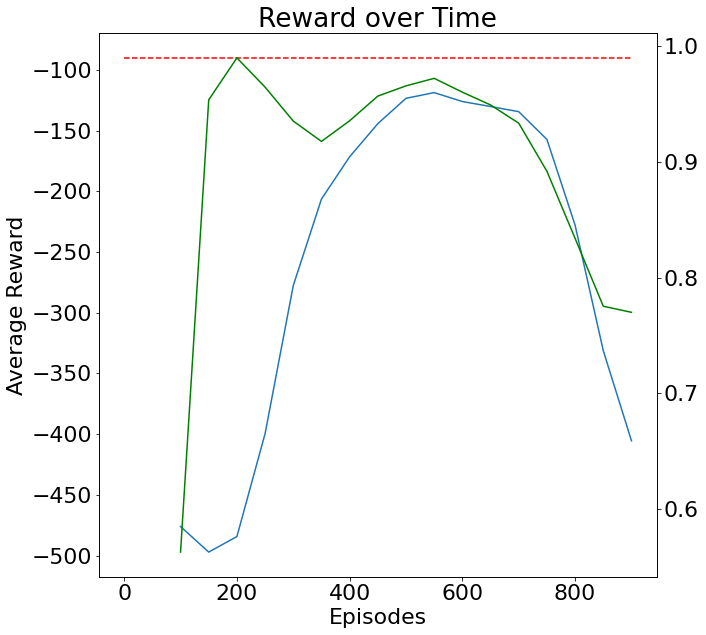

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
    
plt.title('Reward over Time')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')

ax.plot(dat['eps'], dat['reward'], label='reward')
ax.plot([0, dat['eps'][-1]], [-90, -90], color='red', linestyle='dashed')

ax2 = ax.twinx()
ax2.plot(dat['eps'], dat['coop'], color='green')

plt.show()

***
Things for making gifs:

In [ ]:
# tricks to make rendering work in Colab
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
# goal: 0 to 1; action: 0 to 1
def append_action_goal_to_screen(img, goal, action):
    img = np.array(img[:,::-1])
    max_width = 100
    height = 50

    # omit these two lines for HIRO
    goal = goal * 2 - 1
    action = action * 2 - 1

    if goal < 0:
        cv2.rectangle(img, (int(max_width + goal * max_width), 0), (max_width, height), (255, 0, 0), -1) # goal
    else:
        cv2.rectangle(img, (max_width, 0), (int(max_width + goal * max_width), height), (255, 0, 0), -1) # goal
    if action < 0:
        cv2.rectangle(img, (int(max_width + action * max_width), height), (max_width, 2 * height), (0, 0, 255), -1) # action
    else:
        cv2.rectangle(img, (max_width, height), (int(max_width + action * max_width), 2 * height), (0, 0, 255), -1) # action
    return img

In [ ]:
def render_single_episode(hdqnAgent): # HDQN
    hdqnAgent.eval()
    hdqnAgent.meta_controller.eval()
    hdqnAgent.controller.eval()

    max_episode_length = 200
    num_episodes = 100

    frames = []

    overall_reward = 0
    observation = env.reset()

    state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

    episode_steps = 0
    done = False
    while not done:
        # select a goal
        goal = hdqnAgent.select_goal(state)
        goal_i = goal.item()
        encoded_goal = torch.from_numpy(one_hot(2, goal)).float().to(device)

        goal_done = False
        while not done and not goal_done:
            joint_goal_state = torch.cat([encoded_goal, state], axis=1)

            action = hdqnAgent.select_action(joint_goal_state)
            action_i = action.item()

            frames.append(append_action_goal_to_screen(env.render(mode="rgb_array"), goal_i, action_i))

            observation, reward, done, _ = env.step(action_i)

            overall_reward += reward

            if max_episode_length and episode_steps >= max_episode_length - 1:
                done = True
            episode_steps += 1

            goal_done = (goal_i == action_i)

            state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
    return frames, overall_reward

In [ ]:
def render_single_episode(agent): #HIRO
    agent.eval()
    agent.meta_controller.eval()
    agent.controller.eval()

    max_episode_length = 200
    agent.meta_controller.is_training = False
    agent.controller.is_training = False

    num_episodes = 1

    frames = []

    overall_reward = 0
    observation = env.reset()
    # set a large starting angle
    env.state[2] = -env.observation_space.high[2] / 2.0
    observation = np.array(env.state)

    state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

    episode_steps = 0
    done = False
    while not done:
        # select a goal
        goal = agent.select_goal(state, False)

        goal_done = False
        while not done and not goal_done:
            action = agent.select_action(state, goal, False)

            frames.append(append_action_goal_to_screen(env.render(mode="rgb_array"), goal, action))

            observation, reward, done, info = env.step(action.detach().cpu().squeeze(0).numpy())

            next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
            next_goal = agent.h(state, goal, next_state)
                              
            overall_reward += reward

            if max_episode_length and episode_steps >= max_episode_length - 1:
                done = True
            episode_steps += 1

            goal_done = agent.goal_reached(state, goal, next_state)

            state = next_state
            goal = next_goal
    return frames, overall_reward

In [ ]:
frames, overall_reward = render_single_episode(agent)
print(overall_reward)

import pickle
with open('frames.pkl', 'wb') as f:
    pickle.dump(frames, f)

In [ ]:
with open('frames.pkl', 'rb') as f:
    frames = pickle.load(f)
with open('openai_gym.gif', 'wb') as f:
    frames = list(map(lambda x: Image.fromarray(x), frames))
    im = Image.new('RGB', frames[0].size)
    im.save(f, save_all=True, append_images=frames)